# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [9]:
student = "ZHOU Xiao"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [10]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation, Reshape
from keras.optimizers import SGD, Adam
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="1" # 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

KTF.set_session(session )
seed = 7 
np.random.seed(seed)                                       

### Plotting

In [11]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)


def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

### 1.1 Load dataset and plot samples

In [12]:
# load training and test dataset for MNIST and Fashion-MNIST
from keras.datasets import mnist, fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

In [13]:
y_train.shape

(60000,)

******************************Plot samples of training set******************************


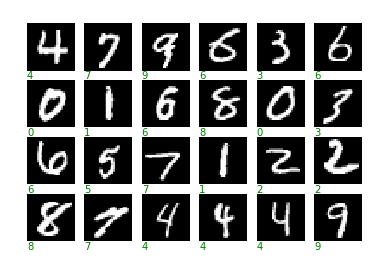

In [14]:
# solution for Question 1
print("******************************Plot samples of training set******************************")
plot_some_samples(x = x_train, y = y_train, yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10))

******************************Plot samples of test set***************


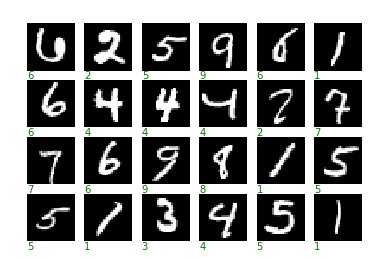

In [15]:
print("******************************Plot samples of test set***************")
plot_some_samples(x = x_test, y = y_test, select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10))

******************************Plot samples of training set******************************


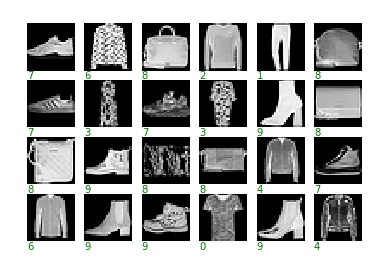

In [16]:
# solution for Question 1
print("******************************Plot samples of training set******************************")
plot_some_samples(x = x_fashion_train, y = y_fashion_train, yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10))

******************************Plot samples of test set***************


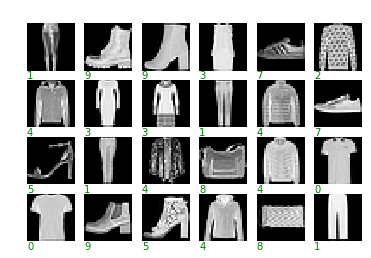

In [17]:
print("******************************Plot samples of test set***************")
plot_some_samples(x = x_fashion_test, y = y_fashion_test, select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10))

### 1.2

__Answer to question 2__: The green digits at the bottom left is the true label of each digit, for example, if the digit is 4, then the corresponding green digit is 5; since we have not trained any model now, there are no predictions for every digit, which give rise to the absence of red digits at the bottom right.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [20]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [19]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [9]:
loss_fn = 'categorical_crossentropy'
hidden_activation = 'relu'
output_activation = 'softmax'
metrics = ['accuracy']
optimizer = 'SGD'
num_neuron = 10
num_hidden_layers = 0 #no hidden layers
num_hidden_neuron = 50
num_output_neuron = 10 # we have 10 output digits
lr = 0.001 # learning rate


def create_nn(input_dim, \
             num_hidden_layers = 0,\
             loss_fn = 'categorical_crossentropy',\
             hidden_activation = 'relu', \
             output_activation = 'softmax',\
             num_hidden_neuron = 50, \
             num_output_neuron = 10,\
             optimizer = 'SGD',\
             metrics = ['accuracy']):
    """
    Input:
          input_dim: single value, the dimenson of input;
          num_hidden_layers: number of hidden layers we employed
          loss_fn: the loss function used, default function would be 'categorical_crossentropy';
          hidden_activation: activation function used in hidden layers;
          output_activation: activation function used in output layers;
          activations: the activation function used, default function would be 'softmax';
          num_hidden_neuron: the number of neurons in the hidden layer;
          num_output_neuron: here indicates the output neuraons, default value is 10 since we have 10 digits
          optimizer: the optimizer method used, default method would be Stochastic Gradient Descent;
          metrics: the deployed metrics used, default metrics is accuracy.
    Output:
          a mlp model
    """
    
    model = Sequential()
    
    if(num_hidden_layers == 0):
        model.add(Dense(num_output_neuron, input_dim = input_dim, activation = output_activation))
        model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
        model.summary()
        return model
    
    #multiple layers
    model.add(Dense(num_hidden_neuron, input_dim = input_dim, activation = hidden_activation))
    for i in range(num_hidden_layers-1):
        model.add(Dense(num_hidden_neuron, input_dim = num_hidden_neuron, activation = hidden_activation))
    model.add(Dense(num_output_neuron, input_dim = num_hidden_neuron, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optim, metrics = metrics)
    model.summary()
    
    return model

In [10]:
# creating model for MNIST
epochs = 150
batch_size = 128
input_dim_MNIST = x_train.shape[1]
input_dim_FASHION = x_fashion_train.shape[1]

hidden_free_model_MNIST = create_nn(input_dim = input_dim_MNIST, num_hidden_layers = 0)
hidden_free_model_fashion_MNIST = create_nn(input_dim = input_dim_FASHION, num_hidden_layers = 0)

hidden_free_history_MNIST = hidden_free_model_MNIST.fit(x_train, y_train,
                                                batch_size=batch_size,
                                                epochs=epochs,
                                                validation_data = (x_test, y_test),
                                                verbose=0)

hidden_free_model_history_fashion_MNIST = hidden_free_model_fashion_MNIST.fit(x_fashion_train, y_fashion_train,
                                                            batch_size=batch_size,
                                                            epochs=epochs,
                                                            validation_data = (x_fashion_test, y_fashion_test),
                                                            verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


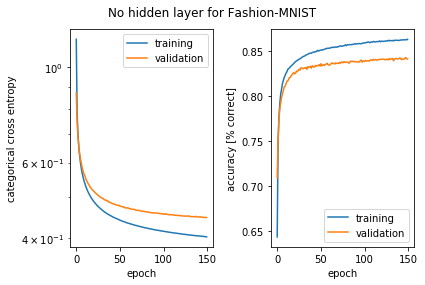

In [11]:
plot_history(hidden_free_model_history_fashion_MNIST, 'No hidden layer for Fashion-MNIST')

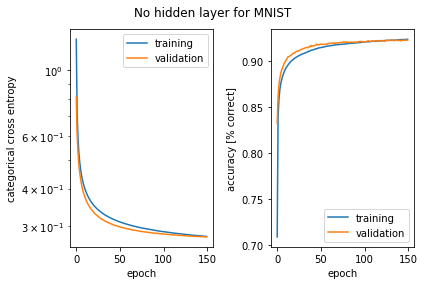

In [12]:
plot_history(hidden_free_history_MNIST, 'No hidden layer for MNIST')

### 2.8 Plot samples by using pre-defined function

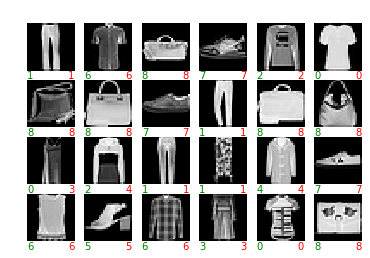

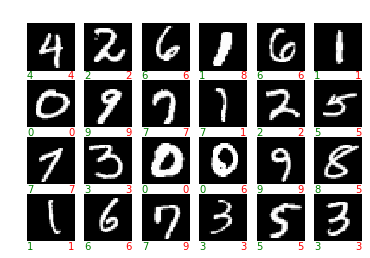

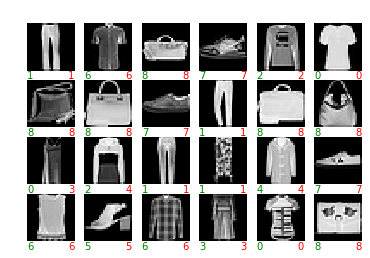

In [13]:
yhat_test_MNIST = hidden_free_model_MNIST.predict(x_test, batch_size=batch_size)
yhat_test_FASHION = hidden_free_model_fashion_MNIST.predict(x_fashion_test, batch_size=batch_size)

plot_some_samples(x_test, y_test, yhat_test_MNIST)
plot_some_samples(x_fashion_test, y_fashion_test, yhat_test_FASHION)

Answer to question 8:   
The green digits at the bottom left is the __true label__ of each digit, and the red digits at the bottom right are __predicted label__.

### 2.9 (we have already run the steps in fashion MNIST together with MNIST above)

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

### 3.1

In [14]:
def create_one_hidden_nn(optimizer, lr=0.01, 
                     input_dim=784, hidden_dim=128,output_dim=10,\
                      hidden_activation='relu',output_activation='softmax',\
                      loss_fn='categorical_crossentropy',metrics=['accuracy']):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation = hidden_activation))
    model.add(Dense(output_dim, input_dim=hidden_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    #model.summary()
    return model

temp_model = create_one_hidden_nn('SGD')
temp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### 3.2

In [15]:
def train_one_hidden_nn(optimizer,lr, batch_size=128, epochs=50,
                       training_data=x_train, training_label=y_train,
                       validation_data=x_test, validation_label=y_test):
    
    # create the model defined above with determined optimizer and learning rate 
    model=create_one_hidden_nn(optimizer,lr)
    # use the model to train through training and validation sets
    history=model.fit(training_data, training_label, validation_data = (validation_data, validation_label),
                        batch_size=batch_size, epochs=epochs,verbose=0)
    score = model.evaluate(validation_data, validation_label, verbose=0)
    return history, score


In [16]:
# define a function that help plot the learning curves of 2 or 3 histories.
def plot_different_histories(history_1, history_2, history_3=None, label_1='', label_2='', label_3='', title=''):
    if history_3==None:
        fig, ax1, ax2 = prepare_standardplot(title, "epochs")
        ax1.plot(history_1.history['loss'], label=label_1 + ' training',c='r')
        ax1.plot(history_1.history['val_loss'], label=label_1 + ' validation',c='r',linestyle='--')
        ax1.plot(history_2.history['loss'], label=label_2 + ' training',c='g')
        ax1.plot(history_2.history['val_loss'], label=label_2 + ' validation',c='g',linestyle='--')
        ax2.plot(history_1.history['acc'], label=label_1 + ' training',c='r')
        ax2.plot(history_1.history['val_acc'], label=label_1 + ' validation',c='r',linestyle='--')
        ax2.plot(history_2.history['acc'], label=label_2 + ' training',c='g')
        ax2.plot(history_2.history['val_acc'], label=label_2 + ' validation',c='g',linestyle='--')
        finalize_standardplot(fig, ax1, ax2)
    else:
        fig, ax1, ax2 = prepare_standardplot(title, "epochs")
        ax1.plot(history_1.history['loss'], label=label_1 + ' training',c='r')
        ax1.plot(history_1.history['val_loss'], label=label_1 + ' validation',c='r',linestyle='--')
        ax1.plot(history_2.history['loss'], label=label_2 + ' training',c='g')
        ax1.plot(history_2.history['val_loss'], label=label_2 + ' validation',c='g',linestyle='--')
        ax1.plot(history_3.history['loss'], label=label_3 + ' training',c='b')
        ax1.plot(history_3.history['val_loss'], label=label_3 + ' validation',c='b',linestyle='--')
        ax2.plot(history_1.history['acc'], label=label_1 + ' training',c='r')
        ax2.plot(history_1.history['val_acc'], label=label_1 + ' validation',c='r',linestyle='--')
        ax2.plot(history_2.history['acc'], label=label_2 + ' training',c='g')
        ax2.plot(history_2.history['val_acc'], label=label_2 + ' validation',c='g',linestyle='--')
        ax2.plot(history_3.history['acc'], label=label_3 + ' training',c='b')
        ax2.plot(history_3.history['val_acc'], label=label_3 + ' validation',c='b',linestyle='--')
        finalize_standardplot(fig, ax1, ax2)

### Here, we fit the model with 2 learning rates as the exercise demands (range: [0.01 , 0.1] )

In [17]:
# train the model with sgd optimizer with 2 learning rates
history_sgd_1,_=train_one_hidden_nn('SGD',lr=0.01)
history_sgd_2,_=train_one_hidden_nn('SGD',lr=0.1)

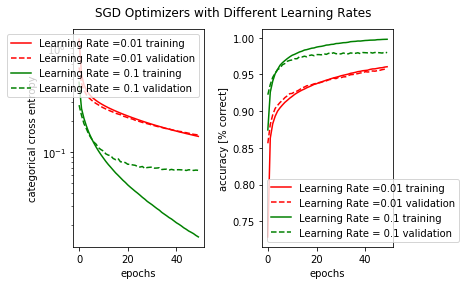

In [18]:
plot_different_histories(history_sgd_1, history_sgd_2, 
                         label_1='Learning Rate =0.01', label_2='Learning Rate = 0.1', 
                         title='SGD Optimizers with Different Learning Rates')

### 3.3

In [19]:
# train the model with adam optimizer with 2 learning rates
history_adam_1,_=train_one_hidden_nn('Adam',lr=0.01)
history_adam_2,_=train_one_hidden_nn('Adam',lr=0.1)

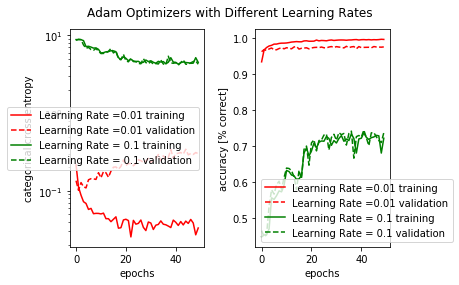

In [20]:
plot_different_histories(history_adam_1, history_adam_2, 
                         label_1='Learning Rate =0.01', label_2='Learning Rate = 0.1', 
                         title='Adam Optimizers with Different Learning Rates')

### 3.4

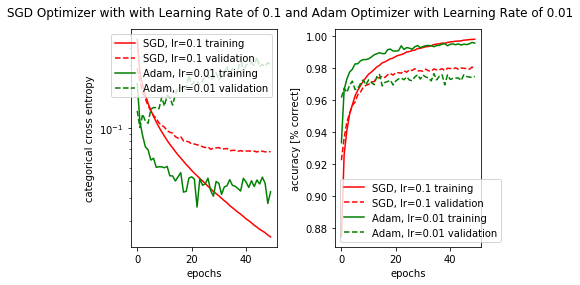

In [21]:
plot_different_histories(history_sgd_2, history_adam_1, 
                         label_1='SGD, lr=0.1', label_2='Adam, lr=0.01', 
                         title='SGD Optimizer with with Learning Rate of 0.1 and Adam Optimizer with Learning Rate of 0.01')

### 3.5

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is very large, it may lead to a fast convergence but it can also cause oscillation around the minima and higher model variance.


B) If the learning rate is very small, convergence is slow and can get stuck in a local "plateau", which may be due to the fact that less information is learned during iterations.


**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: In our model, it starts to overfit after about 10 epochs, i.e. when the validation loss arises and gap between training and validation performance increases.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: In loss curves, the overfitting can be detected through the phenomenon that the validation loss curve does not decrease any more after reaching a minima, but it can gradually increase. In accuracy curves, the validation accuracy curve stays around a constant level without increasing obviously, and the gap between validation and training accuracy becomes larger.
These can be improved by tricks like early stopping.


### 3.6

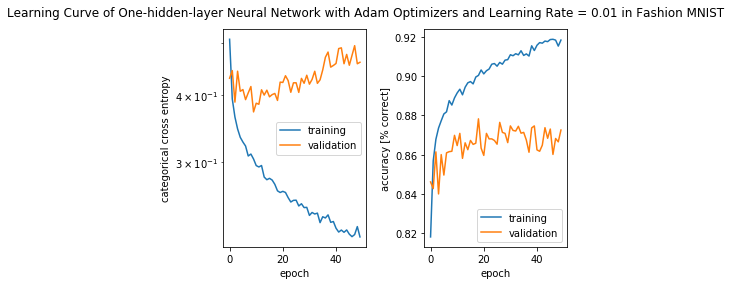

In [22]:
history_adam_fashion,_=train_one_hidden_nn(optimizer='Adam',lr=0.01,
                                          training_data=x_fashion_train, training_label=y_fashion_train,
                                          validation_data=x_fashion_test, validation_label=y_fashion_test)
plot_history(history_adam_fashion, 
             'Learning Curve of One-hidden-layer Neural Network with Adam Optimizers and Learning Rate = 0.01 in Fashion MNIST')

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

### 4.1

### in MNIST

In [15]:
optimizer = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
layer_sizes = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
val_loss_MNIST = []
acc_MNIST = []

val_loss_MNIST_fashion = []
acc_MNIST_fashion = []

batch_size = 128
epochs = 50
###
for layer_size in layer_sizes:
    #define model for MNIST dataset
    model_temp_MNIST  = create_one_hidden_nn(optimizer, hidden_dim=layer_size)
    model_temp_MNIST_history = model_temp_MNIST.fit(x_train, y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data = (x_test, y_test),
                                            verbose=0)
    min_idx_MNIST = model_temp_MNIST_history.history['val_loss'].index(min(model_temp_MNIST_history.history['val_loss']))
    # store for early stopping
    val_loss_MNIST.append(model_temp_MNIST_history.history['val_loss'][min_idx_MNIST])
    acc_MNIST.append(model_temp_MNIST_history.history['val_acc'][min_idx_MNIST])
    
    
    #define model for MNIST-Fashion dataset
    model_temp_MNIST_fashion  = create_one_hidden_nn('Adam', hidden_dim=layer_size)
    model_temp_MNIST_fashion_history = model_temp_MNIST_fashion.fit(x_fashion_train, y_fashion_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data = (x_fashion_test, y_fashion_test),
                                            verbose=0)
    min_idx_fashion = model_temp_MNIST_fashion_history.history['val_loss'].index(min(model_temp_MNIST_fashion_history.history['val_loss']))
    # store for early stopping
    val_loss_MNIST_fashion.append(model_temp_MNIST_fashion_history.history['val_loss'][min_idx_fashion])
    acc_MNIST_fashion.append(model_temp_MNIST_fashion_history.history['val_acc'][min_idx_fashion])
    
    

### 4.2

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
def plot_val(loss, layer_sizes):
    plt.title("Validation Loss Curve versus number of hidden neurons")
    plt.plot(layer_sizes, loss, color='red')
    plt.xlabel('Number of neurons')
    plt.ylabel('Validation Loss')
    plt.show()
    
def plot_acc(acc, layer_sizes):
    plt.title("Accuracy Curve versus number of hidden neurons")
    plt.plot(layer_sizes, acc, color='red')
    plt.xlabel('Number of neurons')
    plt.ylabel('Validation Accuracy')
    plt.show()
    

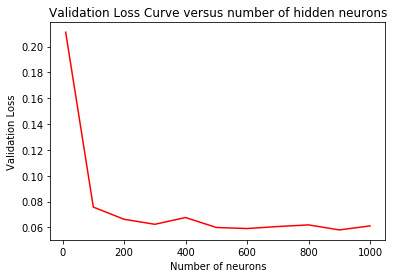

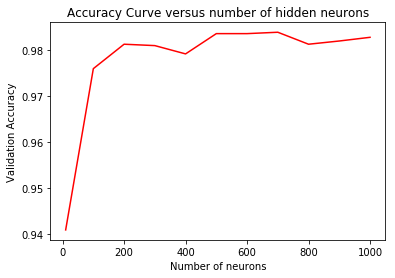

In [17]:
plot_val(val_loss_MNIST,layer_sizes)
plot_acc### in Fashion MNIST### 4.3# we have already fit the model with different hidden layer neuron numbers in fashion MNIST in 4.1
# thus, we only need to plot the curves here.\plot_val(val_loss_MNIST_fashion,layer_sizes)
plot_acc(acc_MNIST_fashion,layer_sizes)(acc_MNIST,layer_sizes)

Answer to question 2:  
According to the __general approximation theorem__, a feed-forward network with a single hidden layer containing a finite number of neurons can approximate continuous functions on compact subsets of $R^n$. From the figure above we could observe that the incresement of accuracy becomes slower and there is even a slight decrease of accuracy with increasing number of neurons. Intuitively, the more neurons we have, the better result we may achieve.  
The more neurons, the more adaptive our model will be. Bigger model capacity will enable the model to learn smaller details, for example, the  __noise__. This is not necessarily a good thing, the noise what our model learned in training set will lead to worse generalization when we apply our model on another dataset: it is easy to understand that the noise existed in the another dataset would possibly be totally different from the noise existed in the trainning set. However, mathematically, the __general approximation theorem__ still works here because the noise pattern is also part of the target function which it aims to approximate.

### 4.3

### in Fashion MNIST

We have already fit the model with different hidden layer neuron numbers in fashion MNIST in 4.1.
 
 Thus, we only need to plot the curves here.

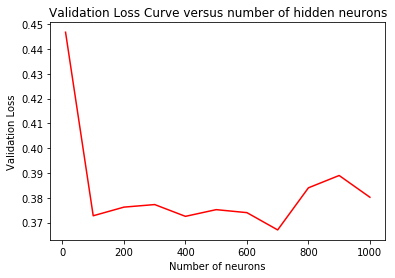

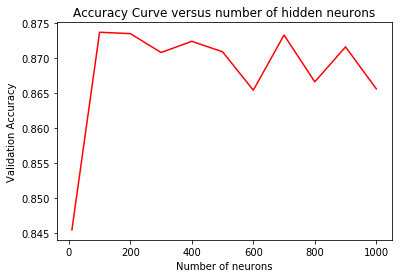

In [18]:
plot_val(val_loss_MNIST_fashion,layer_sizes)
plot_acc(acc_MNIST_fashion,layer_sizes)

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

### 5.1

### Naive Model by adding 2 hidden layers

In [26]:
from keras import regularizers
def create_naive_hidden_nn(optimizer, lr=0.01, 
                     input_dim=784, hidden_dim=128,output_dim=10,\
                      hidden_activation='relu',output_activation='softmax',\
                      loss_fn='categorical_crossentropy',metrics=['accuracy']):
    model = Sequential()
    model.add(Dense(hidden_dim, input_dim=input_dim, activation = hidden_activation))
    for i in range(1):
        model.add(Dense(hidden_dim, input_dim=hidden_dim, activation = hidden_activation))
    model.add(Dense(output_dim, input_dim=hidden_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    return model

In [29]:
# crate naive model and train naive model
model_naive  = create_naive_hidden_nn('Adam', hidden_dim=hidden_dim)
model_naive_history = model_naive.fit(x_fashion_train, y_fashion_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data = (x_fashion_test, y_fashion_test),
                                            verbose=0)

### Tuned Model by adding tricks and regularization

In [27]:
def create_tuned_hidden_nn(optimizer, lr=0.01,
                      input_dim=784, hidden_dim=50, output_dim=10,
                      hidden_activation='relu',
                      output_activation='softmax',
                      loss_fn='categorical_crossentropy',metrics=['accuracy'],
                      kernel_reg = regularizers.l1(0.001),
                      bias_reg = regularizers.l1(0.001),
                      batchNormalization = True,
                      drop_prob = 0):
    
    model = Sequential()
    
    model.add(Dense(hidden_dim, 
                    input_dim=input_dim, 
                    use_bias=True, 
                    kernel_regularizer=kernel_reg, 
                    bias_regularizer = bias_reg)) #activity_regularizer=regularizers.l2(0.001)
    if(batchNormalization):
        model.add(BatchNormalization())
    model.add(Activation(hidden_activation))
    # here we did not need dropout from the input layer which will reduce information
        
    for i in range(1):
        model.add(Dense(hidden_dim, input_dim=hidden_dim))
        if(batchNormalization):
            model.add(BatchNormalization())
        model.add(Activation(hidden_activation))
        if(drop_prob != 0):
            model.add(Dropout(drop_prob))
    model.add(Dense(output_dim, input_dim=hidden_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    return model



### After different experiments with different regularization tricks and parameters,  here we choose the typical tuned parameters with batch normalization(True), dropout(0.15), L1 and L2 regularization on weights and biases.

In [28]:
num_classes = 10
batch_size = 256
epochs = 150
hidden_dim = 50 

# tricks and regularizers we would choose for testing model
kernel_reg = regularizers.l2(0)
bias_reg = regularizers.l2(0)
batchNormalization = True
drop_prob = 0.15

# create tuned model
model_tuned  = create_tuned_hidden_nn('Adam', hidden_dim=hidden_dim,
                                      kernel_reg = kernel_reg,
                                      bias_reg = bias_reg,
                                      batchNormalization = batchNormalization,
                                      drop_prob = drop_prob)
# train tuned model
model_tuned_history = model_tuned.fit(x_fashion_train, y_fashion_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data = (x_fashion_test, y_fashion_test),
                                            verbose=0)

### Learning curves of validation and training set for Tuned Model and Naive Model

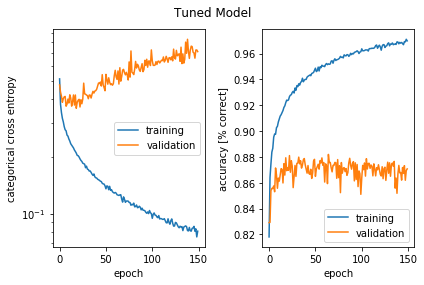

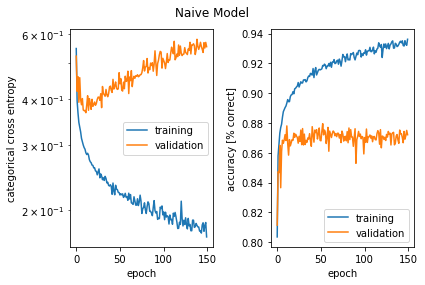

In [15]:
plot_history(model_tuned_history, "Tuned Model")
plot_history(model_naive_history, "Naive Model")

### 5.2 Comparison between tuned model and naive model

### Baseline Model with One Hidden Layer

In [47]:
# only one hidden layer model for FASHION-MNIST 
model_temp_MNIST_fashion  = create_one_hidden_nn('Adam', hidden_dim=50)
model_temp_MNIST_fashion_history = model_temp_MNIST_fashion.fit(x_fashion_train, y_fashion_train,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        validation_data = (x_fashion_test, y_fashion_test),
                                        verbose=0)
min_idx_fashion = model_temp_MNIST_fashion_history.history['val_loss'].index(min(model_temp_MNIST_fashion_history.history['val_loss']))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 50)                39250     
_________________________________________________________________
dense_74 (Dense)             (None, 10)                510       
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________


In [49]:
print("Validation Accuracy with only one hidden layer model for FASHION-MNIST: " + \
      str(model_temp_MNIST_fashion_history.history['val_acc'][min_idx_fashion]))

Validation Accuracy with only one hidden layer model for FASHION-MNIST: 0.8689


### A minor improvemnt we got from 0.878 in naive model to 0.8819 in tuned model

In [14]:
def printBest(model_tuned_history, model_naive_history):
    
    min_idx_tuned = model_tuned_history.history['val_loss'].index(min(model_tuned_history.history['val_loss']))
    min_idx_naive = model_naive_history.history['val_loss'].index(min(model_naive_history.history['val_loss']))
    print("Best validation accuracy of tuned model: " + str( model_tuned_history.history['val_acc'][min_idx_tuned]))
    print("Best validation accuracy of naive model: " + str( model_naive_history.history['val_acc'][min_idx_naive]))

In [18]:
printBest(model_tuned_history, model_naive_history)

Best validation accuracy of tuned model: 0.8819
Best validation accuracy of naive model: 0.878


### Separate Learning Curves are ploted in 5.1

### To observe validation curves of naive model and tuned model better

In [15]:
def plot_tuned_vs_naive(tuned_history, naive_history):
    
    tuned_acc = tuned_history.history['val_acc']
    naive_acc = naive_history.history['val_acc']
    
    tuned_loss = tuned_history.history['val_loss']
    naive_loss = naive_history.history['val_loss']
    
    sub_axix = [i for i in range(len(tuned_acc))]

    plt.figure(1)
    plt.title('Validation accuracy comparision of tuned and naive model')
    plt.plot(sub_axix, tuned_acc, color='green', label='tuned model')
    plt.plot(sub_axix, naive_acc, color='red', label='naive model')
    plt.legend() 
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure(2)
    plt.title('Validation loss comparision of tuned and naive model')
    plt.plot(sub_axix, tuned_loss, color='green', label='tuned model')
    plt.plot(sub_axix, naive_loss, color='red', label='naive model')
    plt.legend() 
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.show()

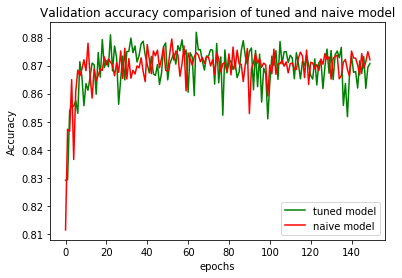

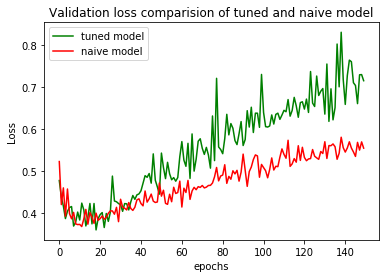

In [19]:
plot_tuned_vs_naive(model_tuned_history, model_naive_history)

### 5.3 Best performing model applied on MNIST

In [54]:
num_classes = 10
batch_size = 256
epochs = 150
hidden_dim = 50 

# tricks and regularizers we would choose for testing model
kernel_reg = regularizers.l2(0)
bias_reg = regularizers.l2(0)
batchNormalization = True
drop_prob = 0.15
model_tuned_MNIST  = create_tuned_hidden_nn('Adam', hidden_dim=hidden_dim,
                                      kernel_reg = regularizers.l2(0),
                                      bias_reg = regularizers.l2(0),
                                      batchNormalization = True,
                                      drop_prob = 0.15)
model_tuned_history_mnist = model_tuned_MNIST.fit(x_train, y_train,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            validation_data = (x_test, y_test),
                                            verbose=0)

Best Validation Accuracy in MNIST by Best Model So Far: 0.9792


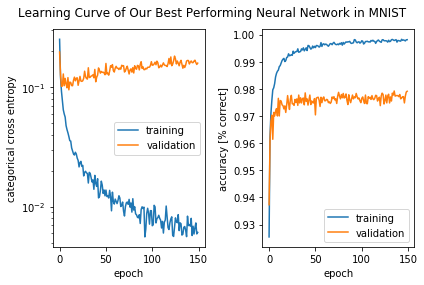

In [55]:
plot_history(model_tuned_history_mnist, 
             'Learning Curve of Our Best Performing Neural Network in MNIST')
print("Best Validation Accuracy in MNIST by Best Model So Far: " + str(max(model_tuned_history_mnist.history['val_acc'])))

#### Answer to question 1(just some notes):  
The final deep regularized model we adopt is: two hidden layers with batch normalizetion and dropout with probability of 0.15(without kernel/bias regularizer), it results in a minor improvement in accuracy from 0.878 to __0.8819__.  
Question 5.2:  
Model performance with only 1 hidden layer applied on MNIST-FASHION will have a best validation accuracy for __0.8689__, which is __less__ than __0.878__ and __0.8819__. It reveals that more deep layer will improve the accuracy, deep model with regularizer and other tricks will also improve the performance.  


#### Answer to question 2 (comments):

To solve the problem of overfitting, we have tried out many combinations. The alternatives we have are:  
(1) Batch Normalization:  Bacth normalizetion could improve the gradient flow and generally it will be placed after the __FC layer__ but before the __Activation layer__;  

(2) Kernel/Bias regularizer: We have tried to use both __L1__ and __L2__ kernel and bias regularizer with several different values range from 0.001 to 0.1, but all of them give rise to lower accuracy, so we believe regularizer is not a good choice in this case, therfore we set them to zero in the final model; 

(4) Dropout: Dropout are effective tricks for reduce overfitting, in our case, since we only have two hidden layers, higher Dropout probability will lead to more loss of useful information, so we adopt a probability of 0.15 by experimenting. We did not introduce dropout for the input layer, because this will give rise to information loss of orginal data and it will be hard for later layer to access them(namely we only use this technique in the hidden layer). 




## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

### 6.1

In [32]:
def create_our_cnn(our_layers, 
                     optimizer='adam', lr=1e-3, 
                     output_dim=10,
                     conv_kernel=3, padding='valid',
                      pooling_kernel=2,
                      hidden_activation='relu',output_activation='softmax',
                      loss_fn='categorical_crossentropy',metrics=['accuracy']):
    '''  input: 
          our_layers: a list of string to represent the layer we create inside the CNN model '''
    # a sign whether we have created a fc layer alreadt
    if_fc=0
    model = Sequential()
    # reshape for convolution operation
    model.add(Reshape((28,28,1), input_shape=(784,)))
    for temp_layer in our_layers[0:]:
        if temp_layer[0]=='c':
            # if the string starts with 'c', then it's a convolution layer, the channel number is the digit after 'c'
            temp_channel=int(temp_layer[1:])
            model.add(Conv2D(temp_channel,kernel_size=(conv_kernel, conv_kernel), activation=hidden_activation,padding=padding))
        if temp_layer[0]=='m':
            # if the string starts with 'm', then it's a max pooling layer
            model.add(MaxPooling2D(pool_size=(pooling_kernel, pooling_kernel)))
        if temp_layer[0]=='d':
            # if the string starts with 'd', then it's a dropout, the probability is the number after 'd'
            prob=float(temp_layer[1:])
            model.add(Dropout(prob))
        if temp_layer[:2]=='bn':
            # if the string starts with 'bn', then it's batch normalization
            model.add(BatchNormalization())
        if temp_layer[:2]=='fc':
            # if the string starts with 'fc', then it's a fc layer, the neuron number is the digit after 'fc'
            temp_dim=int(temp_layer[2:])
            # if we have not created fc yet, we need to flatten the layer for fc operation.
            if if_fc==0:
                model.add(Flatten())
            model.add(Dense(temp_dim, activation = hidden_activation))
            if_fc=1
    model.add(Dense(output_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    #model.summary()
    return model
    

In [33]:
our_layers_1=['c16','m','d0.5','c32','m','d0.5','c64','m','d0.5','fc128']
our_cnn_1=create_our_cnn(our_layers_1)
our_cnn_1.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
__________

In [34]:
our_layers_2=['c16','c32','m','d0.5','c64','c64','m','d0.5','fc128']
our_cnn_2=create_our_cnn(our_layers_2,padding='same')
our_cnn_2.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        36928     
__________

### 6.2

### In MNIST

In [35]:
def train_our_cnn(our_layers,
                    optimizer='adam',lr=1e-3, 
                    batch_size=128, epochs=150,
                    output_dim=10,
                     conv_kernel=3, padding='valid',
                      pooling_kernel=2,
                      hidden_activation='relu',output_activation='softmax',
                      loss_fn='categorical_crossentropy',metrics=['accuracy'],
                     training_data=x_train, training_label=y_train,
                     validation_data=x_test, validation_label=y_test):
    
    model=create_our_cnn(our_layers, optimizer, lr,
                          output_dim=output_dim,
                          conv_kernel=conv_kernel,pooling_kernel=pooling_kernel,
                          hidden_activation=hidden_activation, output_activation=output_activation,
                          loss_fn=loss_fn, metrics=metrics)
    
    history=model.fit(training_data, training_label, 
                        batch_size=batch_size, epochs=epochs,verbose=0,
                        validation_data = (validation_data, validation_label))
    score = model.evaluate(validation_data, validation_label, verbose=0)
    return model,history, score

In [36]:
our_layers_1=['c16','m','d0.5','c32','m','d0.5','c64','m','d0.5','fc128']
our_cnn_1_mnist,cnn_history_1_mnist,_=train_our_cnn(our_layers_1)

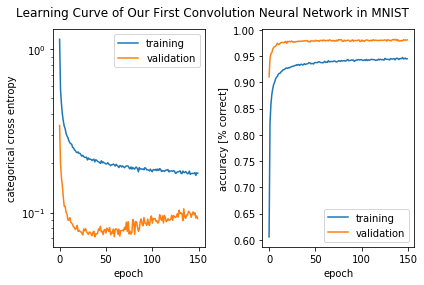

In [37]:
plot_history(cnn_history_1_mnist, 
             'Learning Curve of Our First Convolution Neural Network in MNIST') 

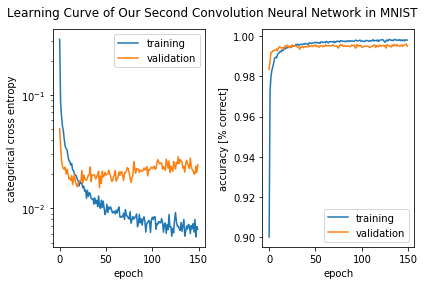

In [38]:
our_cnn_2_mnist,cnn_history_2_mnist,_=train_our_cnn(our_layers_2)
plot_history(cnn_history_2_mnist, 
             'Learning Curve of Our Second Convolution Neural Network in MNIST')

Best Validation Accuracy by 1st CNN: 0.9823
Best Validation Accuracy by 2st CNN: 0.996


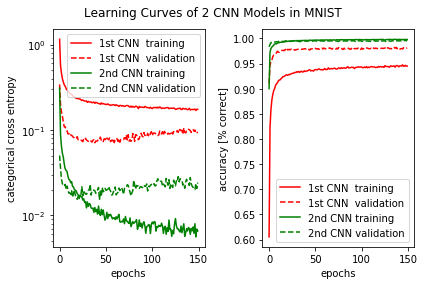

In [39]:
plot_different_histories(cnn_history_1_mnist, cnn_history_2_mnist, 
                         label_1='1st CNN ', label_2='2nd CNN', 
                         title='Learning Curves of 2 CNN Models in MNIST')
print("Best Validation Accuracy by 1st CNN: " + str(max(cnn_history_1_mnist.history['val_acc'])))
print("Best Validation Accuracy by 2st CNN: " + str(max(cnn_history_2_mnist.history['val_acc'])))

### In Fashion MNIST

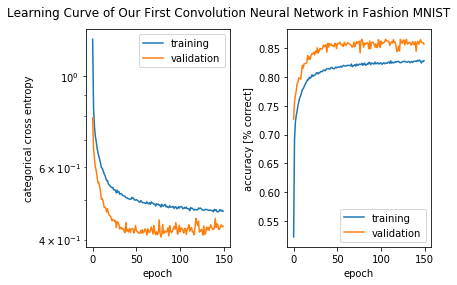

In [40]:
our_layers_1=['c16','m','d0.5','c32','m','d0.5','c64','m','d0.5','fc128']
our_cnn_1_fashion,cnn_history_1_fashion,_=train_our_cnn(our_layers_1,
                                             training_data=x_fashion_train, training_label=y_fashion_train,
                                             validation_data=x_fashion_test, validation_label=y_fashion_test)
plot_history(cnn_history_1_fashion, 
             'Learning Curve of Our First Convolution Neural Network in Fashion MNIST')

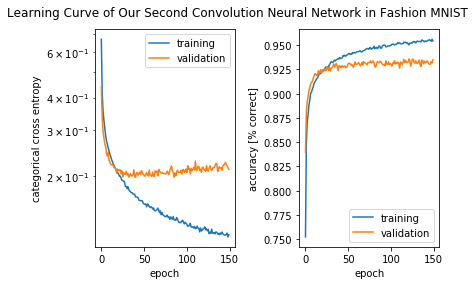

In [41]:
our_layers_2=['c16','c32','m','d0.5','c64','c64','m','d0.5','fc128']
our_cnn_2_fashion,cnn_history_2_fashion,_=train_our_cnn(our_layers_2,
                                             training_data=x_fashion_train, training_label=y_fashion_train,
                                             validation_data=x_fashion_test, validation_label=y_fashion_test)
plot_history(cnn_history_2_fashion, 
             'Learning Curve of Our Second Convolution Neural Network in Fashion MNIST')

Best Validation Accuracy by 1st CNN in Fashion MNIST: 0.866
Best Validation Accuracy by 2st CNN in Fashion MNIST: 0.9359


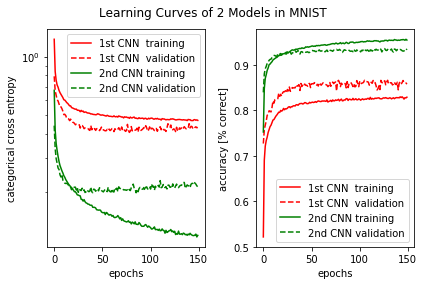

In [42]:
plot_different_histories(cnn_history_1_fashion, cnn_history_2_fashion, 
                         label_1='1st CNN ', label_2='2nd CNN', 
                         title='Learning Curves of 2 Models in MNIST')
print("Best Validation Accuracy by 1st CNN in Fashion MNIST: " + str(max(cnn_history_1_fashion.history['val_acc'])))
print("Best Validation Accuracy by 2st CNN in Fashion MNIST: " + str(max(cnn_history_2_fashion.history['val_acc'])))

### 6.3

### Comparison in MNIST

In [58]:
print("Best Validation Accuracy by Best MLP in MNIST: " + str(max(model_tuned_history_mnist.history['val_acc'])))
print("Best Validation Accuracy by CNN in MNIST: " + str(max(cnn_history_2_mnist.history['val_acc'])))

Best Validation Accuracy by Best MLP in MNIST: 0.9792
Best Validation Accuracy by CNN in MNIST: 0.996


### Comparison in Fashion MNIST

In [61]:
print("Best Validation Accuracy by Best MLP in Fashion MNIST: " + str(max(model_tuned_history.history['val_acc'])))
print("Best Validation Accuracy by CNN in Fashion MNIST: " + str(max(cnn_history_2_fashion.history['val_acc'])))

Best Validation Accuracy by Best MLP in Fashion MNIST: 0.8819
Best Validation Accuracy by CNN in Fashion MNIST: 0.9359


Answer to question 3:

It can be observed that CNN outperforms our best dense neural network in MNIST and fashion MNIST dataset, which proves that CNN models have an inductive bias that is well adapted to image classification. 
The performance difference gap is larger in Fashion MNIST. 


## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

### 7.1

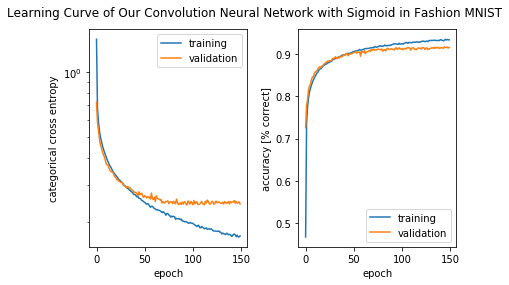

In [44]:
# same structure as in our 2nd CNN
our_layers_3=our_layers_2
# only change the hidden_activation to sigmoid
our_cnn_3_fashion,cnn_history_3_fashion,_=train_our_cnn(our_layers_3, 
                                             hidden_activation='sigmoid',
                                             training_data=x_fashion_train, training_label=y_fashion_train,
                                             validation_data=x_fashion_test, validation_label=y_fashion_test)
plot_history(cnn_history_3_fashion, 
             'Learning Curve of Our Convolution Neural Network with Sigmoid in Fashion MNIST')

In [45]:
our_cnn_3_fashion.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 64)          36928     
__________

In [46]:
our_cnn_3_fashion.save_weights('our_cnn_3_fashion.h5')

Best Validation Accuracy by CNN With Relu in Fashion MNIST: 0.9359
Best Validation Accuracy by CNN With Sigmoid in Fashion MNIST: 0.9167


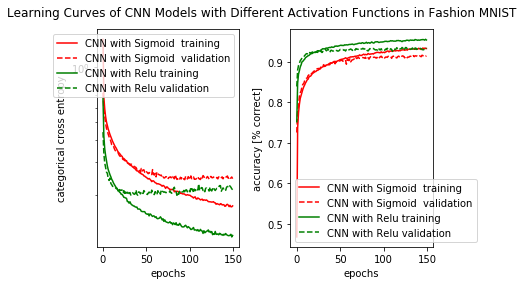

In [47]:
plot_different_histories(cnn_history_3_fashion, cnn_history_2_fashion, 
                         label_1='CNN with Sigmoid ', label_2='CNN with Relu', 
                         title='Learning Curves of CNN Models with Different Activation Functions in Fashion MNIST')
print("Best Validation Accuracy by CNN With Relu in Fashion MNIST: " + str(max(cnn_history_2_fashion.history['val_acc'])))
print("Best Validation Accuracy by CNN With Sigmoid in Fashion MNIST: " + str(max(cnn_history_3_fashion.history['val_acc'])))

### 7.2

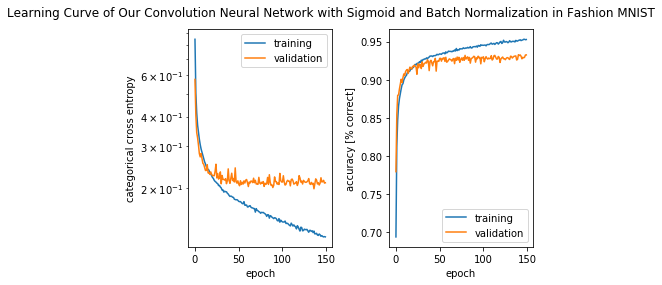

In [48]:
our_layers_4=['bn','c16','bn','c32','m','d0.5','bn','c64','bn','c64','m','d0.5','bn','fc128','bn']
our_cnn_4_fashion,cnn_history_4_fashion,_=train_our_cnn(our_layers_4, 
                                             hidden_activation='sigmoid',
                                             training_data=x_fashion_train, training_label=y_fashion_train,
                                             validation_data=x_fashion_test, validation_label=y_fashion_test)
plot_history(cnn_history_4_fashion, 
             'Learning Curve of Our Convolution Neural Network with Sigmoid and Batch Normalization in Fashion MNIST')

In [49]:
our_cnn_4_fashion.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 12, 12, 32)        0         
__________

In [50]:
our_cnn_4_fashion.save_weights('our_cnn_4_fashion.h5')

Best Validation Accuracy by CNN With Relu in Fashion MNIST: 0.9359
Best Validation Accuracy by CNN With Sigmoid in Fashion MNIST: 0.9167
Best Validation Accuracy by CNN With Sigmoid and Batch Normalization in Fashion MNIST: 0.9328


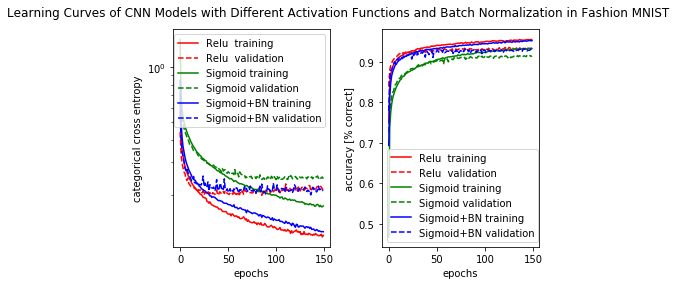

In [51]:
plot_different_histories(cnn_history_2_fashion, cnn_history_3_fashion, history_3=cnn_history_4_fashion,
                         label_1='Relu ', label_2='Sigmoid', label_3='Sigmoid+BN',
                         title='Learning Curves of CNN Models with Different Activation Functions and Batch Normalization in Fashion MNIST')
print("Best Validation Accuracy by CNN With Relu in Fashion MNIST: " + str(max(cnn_history_2_fashion.history['val_acc'])))
print("Best Validation Accuracy by CNN With Sigmoid in Fashion MNIST: " + str(max(cnn_history_3_fashion.history['val_acc'])))
print("Best Validation Accuracy by CNN With Sigmoid and Batch Normalization in Fashion MNIST: " 
        + str(max(cnn_history_4_fashion.history['val_acc'])))

Answer to question 1:

It can be observed that the performance of same CNN model with sigmoid activation is not as good as that with relu activation, which may be due to that gradient vanishing caused by saturating activity of sigmoid.

Answer to question 2:

It can be observed that batch normalization can help improve network performance, and make it very close to the performance with relu activation.